In [1]:
#use the Google Directions API for calling drive time and public transit time
#for different neighborhood home and office locations around Denver
#complete for one work week in the future (non-Holiday week)
#departure at 8am and return at 5pm

In [2]:
import os
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps
import time
google_maps_api_key = os.environ.get('googlemaps_api_key')

In [3]:
df = pd.read_csv('raw_data\\Neighborhood_House_Rents_Regions.csv')
df.drop('Unnamed: 0', axis='columns', inplace=True)
df.head(3)

,Neighborhood,House Value,Median Rent,POPULATION_2010,PCT_WHITE,DENVER_REGION
0,Montbello,174000.0,1854.0,30348,8.17,Northeast
1,Gateway - Green Valley Ranch,208600.0,1951.0,29201,23.98,Northeast
2,Hampden,297900.0,2138.0,17547,66.96,Southeast


In [4]:
#https://developers.google.com/maps/documentation/directions/intro
#start is the location start at
#end is the location end at
#leave_time is time to leave at in seconds since midnight, January 1, 1970 UTC
#travel_mode is either driving or transit
def get_directions(start, end, leave_time, travel_mode):
    #https://maps.googleapis.com/maps/api/directions/outputFormat?parameters   
    base_url = 'https://maps.googleapis.com/maps/api/directions/json?'
    parameters = {'origin': start, 
                  'destination': end,
                  'departure_time': leave_time, #now or an integer in seconds since midnight, January 1, 1970 UTC
                  'mode': travel_mode,  #driving or transit
                  'key': google_maps_api_key
                  }

    request = requests.get(base_url, parameters)
    directions = request.json()
    return directions

In [5]:
#in order to specify departure_time on directions API, need the time
#in seconds since midnight, January 1, 1970 UTC, so convert this with this function
#time_string must be in this format: '2018-07-09 8:00:00'
#the google maps api automatically account for timezone issues when give in the UTC time
def time_seconds_since_1970(time_string):
    time_secs = int(time.mktime(time.strptime(time_string, '%Y-%m-%d %H:%M:%S')))
    return time_secs

In [6]:
# #morning commute Monday June 9th - Friday June 13th at 8am
# #afternoon commute Monday June 9th - Friday June 13th at 5pm (17:00)
# morning_commutes = [f"2018-07-{x} 8:00:00" for x in range(9,14)]
# afternoon_commutes = [f"2018-07-{x} 17:00:00" for x in range(9,14)]
# print(morning_commutes)
# print(afternoon_commutes)

#can only do 2500 API pulls a day for free, so just pick a Tuesday of a normal week
morning_commute_time = time_seconds_since_1970('2018-07-10 8:00:00')
afternoon_commute_time = time_seconds_since_1970('2018-07-10 17:00:00')
#commute destination (morning) and starting point (afternoon) for each 
#neighborhood calculation
commute_locations = ['Colorado Convention Center', 'University of Denver',
                    'Denver Tech Center', 'University of Colorado Boulder']
commute_labels = ['Downtown', 'DU', 'DTC', 'CU-Boulder']

In [8]:
#get JSONs for each neighborhood for morning/afternoon commutes both driving/transit
#need to add 'Neighborhood, Denver, CO' to all neighborhoods to make sure it looks for the 
#neighborhood in Denver area and not some random spot somewhere else in country
#the commute locations are specific enough, that it will automatically look in Denver/Boulder
for index, commute_loc in enumerate(commute_locations):
    commute_label = commute_labels[index]
    print(commute_label)
    
    df[f"drive-AM-to-{commute_label}"] = df.Neighborhood.map(lambda x:
            get_directions(f"{x} Neighborhood, Denver, CO", commute_loc, 
                           morning_commute_time, 'driving'))
    df[f"transit-AM-to-{commute_label}"] = df.Neighborhood.map(lambda x:
            get_directions(f"{x} Neighborhood, Denver, CO", commute_loc,
                           morning_commute_time, 'transit'))
    df[f"drive-PM-from-{commute_label}"] = df.Neighborhood.map(lambda x:
            get_directions(commute_loc, f"{x} Neighborhood, Denver, CO",
                           afternoon_commute_time, 'driving'))
    df[f"transit-PM-from-{commute_label}"] = df.Neighborhood.map(lambda x:
            get_directions(commute_loc, f"{x} Neighborhood, Denver, CO",
                           afternoon_commute_time, 'transit'))

df.head()

Downtown
DU
DTC
CU-Boulder


,Neighborhood,House Value,Median Rent,POPULATION_2010,PCT_WHITE,DENVER_REGION,drive-AM-to-Downtown,transit-AM-to-Downtown,drive-PM-from-Downtown,transit-PM-from-Downtown,...,drive-PM-from-DU,transit-PM-from-DU,drive-AM-to-DTC,transit-AM-to-DTC,drive-PM-from-DTC,transit-PM-from-DTC,drive-AM-to-CU-Boulder,transit-AM-to-CU-Boulder,drive-PM-from-CU-Boulder,transit-PM-from-CU-Boulder
0,Montbello,174000.0,1854.0,30348,8.17,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...
1,Gateway - Green Valley Ranch,208600.0,1951.0,29201,23.98,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...
2,Hampden,297900.0,2138.0,17547,66.96,Southeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...
3,Westwood,152600.0,1675.0,15486,11.39,West,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...
4,Capitol Hill,197600.0,1534.0,14708,78.56,Central,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_st

In [9]:
#get duration works for transit or driving time 
def get_duration(directions_json):
    duration = directions_json.get('routes')[0].get('legs')[0].get('duration').get('value')/60
    return duration #in minutes
    
#when mode is 'driving' API will take into account traffic time based on historical info with duration_in_traffic return
def get_drive_time_traffic(directions_json):
    drive_time_traffic = directions_json.get('routes')[0].get('legs')[0].get('duration_in_traffic').get('value')/60
    return drive_time_traffic #in minutes

# #below seemed to be isolated concern, and these values actually don't account for wait time, so less than real
# #it appears that duration for transit time isn't giving real time values, so instead sum up the time of each step
# def get_transit_sum_durations(direction_json):
#     step_times = [x.get('duration').get('value')/60 for x in
#               direction_json.get('routes')[0].get('legs')[0].get('steps')]
#     sum_durations = sum(step_times)
#     return sum_durations

In [10]:
#testing functions
print(df['Neighborhood'][0])
print('driving')
print(get_duration(df['drive-AM-to-DU'][0]))
print(get_drive_time_traffic(df['drive-AM-to-DU'][0]))
print('transit')
print(get_duration(df['transit-AM-to-DU'][0]))

Montbello
driving
26.116666666666667
41.3
transit
90.25


In [11]:
#calculate how badly rush hour affects average drive time by giving percentage
#slower (if returns negative, then it'd be faster)
def rush_hour_percent_slower_drive(directions_drive_json):
    time_no_traffic = get_duration(directions_drive_json)
    rush_hour_time = get_drive_time_traffic(directions_drive_json)
    traffic_percent_slower = (rush_hour_time - time_no_traffic) / time_no_traffic * 100
    return traffic_percent_slower

#calculate how much slower transit is than driving by giving percentage slower
#if it returns negative than it is that percentage faster than driving
#if it returns zero then it is same time as driving
def transit_percent_slower(directions_drive_json, directions_transit_json):
    drive_time_traffic = get_drive_time_traffic(directions_drive_json)
    transit_time = get_duration(directions_transit_json)
    transit_percent_slower = (transit_time - drive_time_traffic) / drive_time_traffic * 100
    return transit_percent_slower

In [12]:
#testing functions
print(df['Neighborhood'][0])
print('% slower drive in rush hour: ', rush_hour_percent_slower_drive(df['drive-AM-to-DU'][0]))
print('% slower transit than drive: ', transit_percent_slower(df['drive-AM-to-DU'][0], df['transit-AM-to-DU'][0]))

Montbello
% slower drive in rush hour:  58.13656668793872
% slower transit than drive:  118.52300242130751


In [13]:
#testing functions
print(df['Neighborhood'][40])
print('% slower drive in rush hour: ', rush_hour_percent_slower_drive(df['drive-AM-to-DU'][40]))
print('% slower transit than drive: ', transit_percent_slower(df['drive-AM-to-DU'][40], df['transit-AM-to-DU'][40]))

Hale
% slower drive in rush hour:  17.74193548387097
% slower transit than drive:  133.60193392425467


In [16]:
#testing functions
print(df['Neighborhood'][73])
print('driving')
print(get_duration(df['drive-AM-to-DU'][73]))
print(get_drive_time_traffic(df['drive-AM-to-DU'][73]))
print('transit')
print(get_duration(df['transit-AM-to-DU'][73]))

Civic Center
driving
15.133333333333333
18.3
transit
41.68333333333333


In [19]:
#for each neighborhood (each row of dataframe) and our four driving commute locations (in columns)
#and AM/PM times calculate how much slower drive time is in traffic
#and how much slower transit time is
for commute_label in commute_labels:
    for time in ['AM-to', 'PM-from']:
        df[f"% Slower Rush Hour Drive {time}-{commute_label}"] = df[
            f"drive-{time}-{commute_label}"].map(rush_hour_percent_slower_drive)
        df[f"Transit % Slower {time}-{commute_label}"] = df.apply(lambda x:
                transit_percent_slower(x[f"drive-{time}-{commute_label}"], x[f"transit-{time}-{commute_label}"]),
                axis=1)

In [20]:
df.head()

,Neighborhood,House Value,Median Rent,POPULATION_2010,PCT_WHITE,DENVER_REGION,drive-AM-to-Downtown,transit-AM-to-Downtown,drive-PM-from-Downtown,transit-PM-from-Downtown,...,% Slower Rush Hour Drive PM-from-DU,Transit % Slower PM-from-DU,% Slower Rush Hour Drive AM-to-DTC,Transit % Slower AM-to-DTC,% Slower Rush Hour Drive PM-from-DTC,Transit % Slower PM-from-DTC,% Slower Rush Hour Drive AM-to-CU-Boulder,Transit % Slower AM-to-CU-Boulder,% Slower Rush Hour Drive PM-from-CU-Boulder,Transit % Slower PM-from-CU-Boulder
0,Montbello,174000.0,1854.0,30348,8.17,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,50.792557,145.612431,49.225092,124.727992,36.724566,220.931639,69.955379,100.408401,47.541766,106.599806
1,Gateway - Green Valley Ranch,208600.0,1951.0,29201,23.98,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,48.036810,148.984666,56.443832,200.352423,35.878963,205.355249,16.809006,102.592223,4.315476,149.179743
2,Hampden,297900.0,2138.0,17547,66.96,Southeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,44.604317,121.641791,9.702660,107.560628,18.167457,108.288770,47.749900,106.280323,51.106026,59.111560
3,Westwood,152600.0,1675.0,15486,11.39,West,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,10.632447,160.977630,88.411669,87.311828,75.334324,93.177966,39.914974,101.417961,39.929015,94.229550
4,Capitol Hill,197600.0,1534.0,14708,78.56,Central,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,19.897959,159.914894,52.433281,84.912461,38.058552,105.970982,36.316533,46.648238,39.241071,43.443411


In [21]:
#then finally calculate an average for each neighborhood that
#just averages our four drive commute location %s (both AM and PM) to use in summarizing
#the average % slower rush hour drive and the average transit % slower for each neighborhood

#because column titles are so long, automate a list of columns want to average out
rush_hour_columns_to_average = []
for commute_label in commute_labels:
    for time in ['AM-to', 'PM-from']:
        rush_hour_columns_to_average.append(f"% Slower Rush Hour Drive {time}-{commute_label}")

transit_slower_columns_to_average = []
for commute_label in commute_labels:
    for time in ['AM-to', 'PM-from']:
        transit_slower_columns_to_average.append(f"Transit % Slower {time}-{commute_label}")

#calculate averages and store in new columns
df[f"Average % Slower Rush Hour Drive"] = df[rush_hour_columns_to_average].mean(axis=1)
df[f"Average Transit % Slower"] = df[transit_slower_columns_to_average].mean(axis=1)

In [22]:
df.head()

,Neighborhood,House Value,Median Rent,POPULATION_2010,PCT_WHITE,DENVER_REGION,drive-AM-to-Downtown,transit-AM-to-Downtown,drive-PM-from-Downtown,transit-PM-from-Downtown,...,% Slower Rush Hour Drive AM-to-DTC,Transit % Slower AM-to-DTC,% Slower Rush Hour Drive PM-from-DTC,Transit % Slower PM-from-DTC,% Slower Rush Hour Drive AM-to-CU-Boulder,Transit % Slower AM-to-CU-Boulder,% Slower Rush Hour Drive PM-from-CU-Boulder,Transit % Slower PM-from-CU-Boulder,Average % Slower Rush Hour Drive,Average Transit % Slower
0,Montbello,174000.0,1854.0,30348,8.17,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,49.225092,124.727992,36.724566,220.931639,69.955379,100.408401,47.541766,106.599806,61.359118,124.838121
1,Gateway - Green Valley Ranch,208600.0,1951.0,29201,23.98,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,56.443832,200.352423,35.878963,205.355249,16.809006,102.592223,4.315476,149.179743,48.168008,132.352911
2,Hampden,297900.0,2138.0,17547,66.96,Southeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,9.702660,107.560628,18.167457,108.288770,47.749900,106.280323,51.106026,59.111560,37.639157,99.242317
3,Westwood,152600.0,1675.0,15486,11.39,West,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,88.411669,87.311828,75.334324,93.177966,39.914974,101.417961,39.929015,94.229550,40.214573,110.209966
4,Capitol Hill,197600.0,1534.0,14708,78.56,Central,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,52.433281,84.912461,38.058552,105.970982,36.316533,46.648238,39.241071,43.443411,28.317762,92.355886


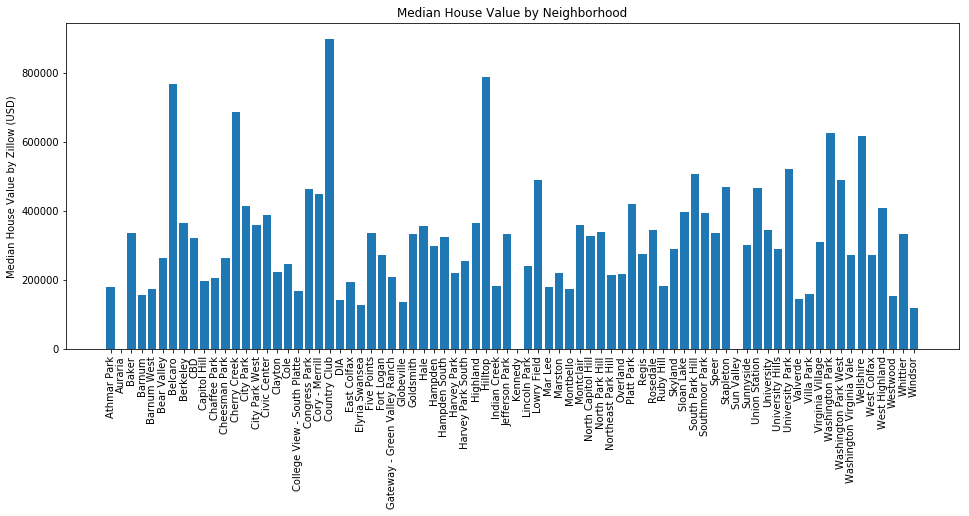

In [23]:
plt.figure(figsize=(16,6))
plt.bar(df['Neighborhood'], df['House Value'])
plt.title('Median House Value by Neighborhood')
plt.xticks(rotation='vertical')
plt.ylabel('Median House Value by Zillow (USD)')
plt.show()

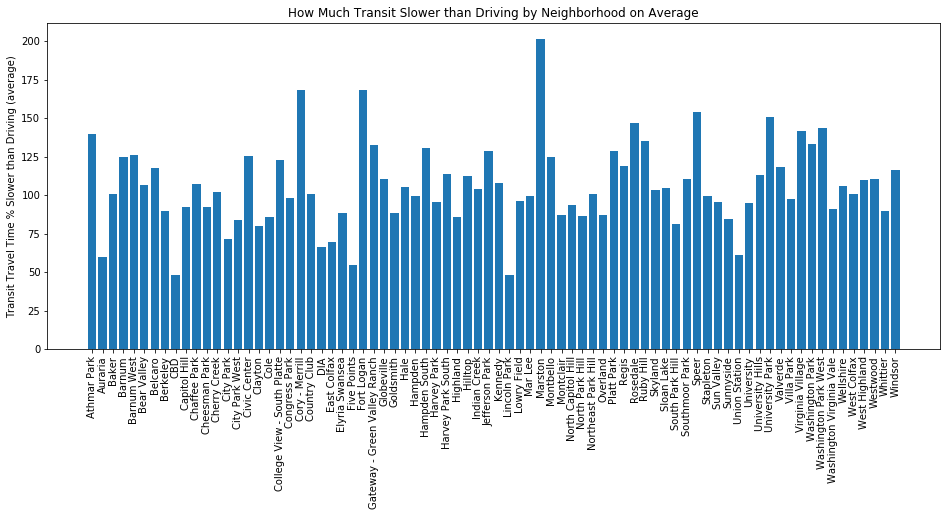

In [25]:
plt.figure(figsize=(16,6))
plt.bar(df['Neighborhood'], df['Average Transit % Slower'])
plt.title('How Much Transit Slower than Driving by Neighborhood on Average')
plt.xticks(rotation='vertical')
plt.ylabel('Transit Travel Time % Slower than Driving (average)')
plt.show()

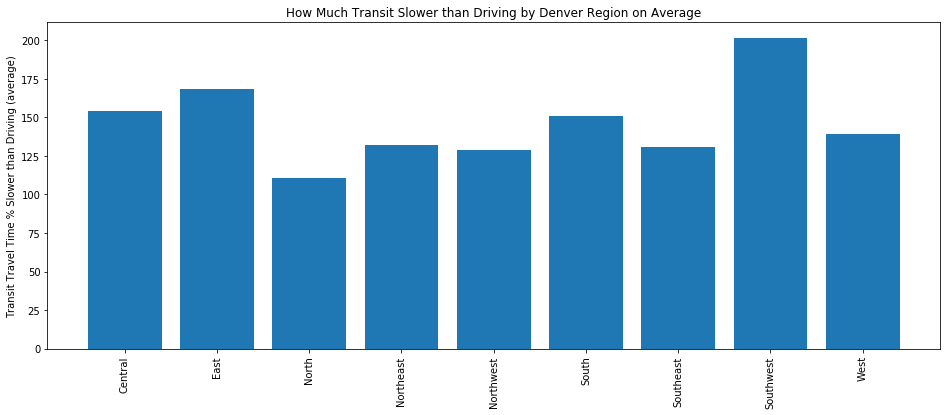

In [37]:
plt.figure(figsize=(16,6))
plt.bar(df['DENVER_REGION'], df['Average Transit % Slower'])
plt.title('How Much Transit Slower than Driving by Denver Region on Average')
plt.xticks(rotation='vertical')
plt.ylabel('Transit Travel Time % Slower than Driving (average)')
plt.show()

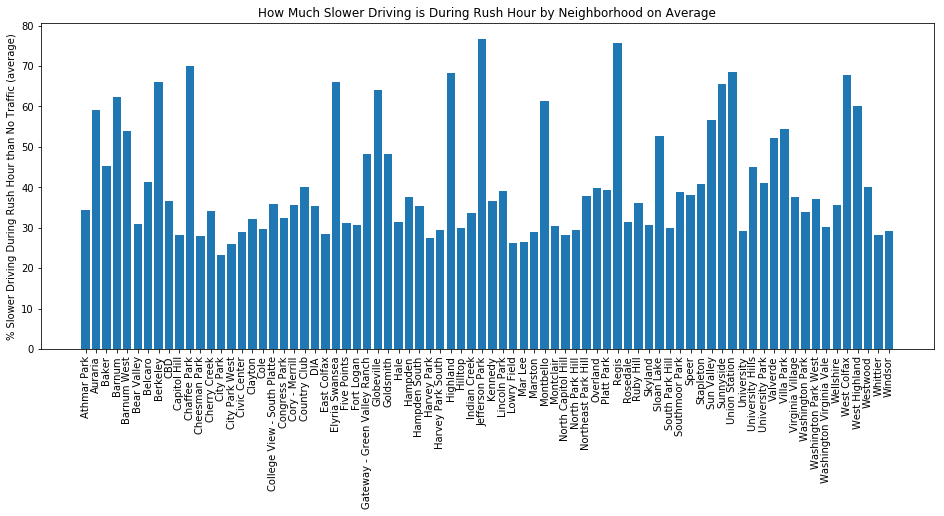

In [31]:
plt.figure(figsize=(16,6))
plt.bar(df['Neighborhood'], df['Average % Slower Rush Hour Drive'])
plt.title('How Much Slower Driving is During Rush Hour by Neighborhood on Average')
plt.xticks(rotation='vertical')
plt.ylabel('% Slower Driving During Rush Hour than No Traffic (average)')
plt.show()

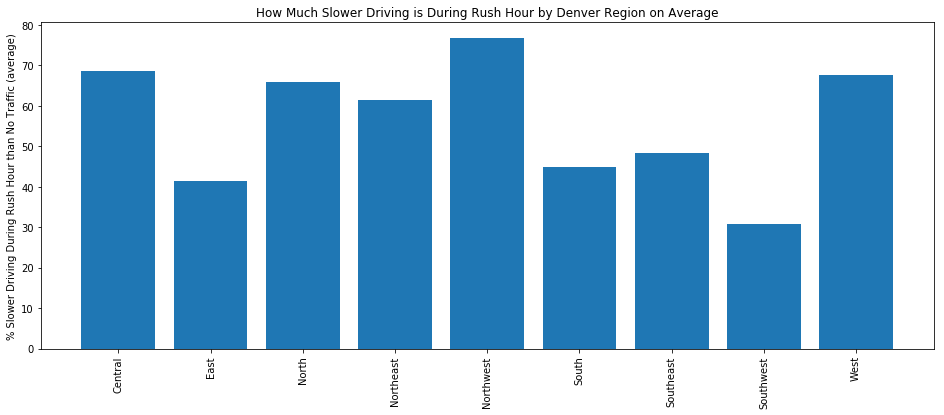

In [34]:
plt.figure(figsize=(16,6))
plt.bar(df['DENVER_REGION'], df['Average % Slower Rush Hour Drive'])
plt.title('How Much Slower Driving is During Rush Hour by Denver Region on Average')
plt.xticks(rotation='vertical')
plt.ylabel('% Slower Driving During Rush Hour than No Traffic (average)')
plt.show()

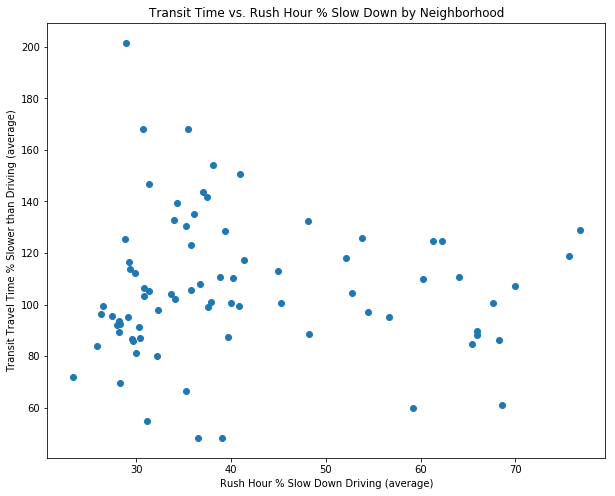

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(df['Average % Slower Rush Hour Drive'], df['Average Transit % Slower'])
plt.title('Transit Time vs. Rush Hour % Slow Down by Neighborhood')
plt.xlabel('Rush Hour % Slow Down Driving (average)')
plt.ylabel('Transit Travel Time % Slower than Driving (average)')
plt.show()

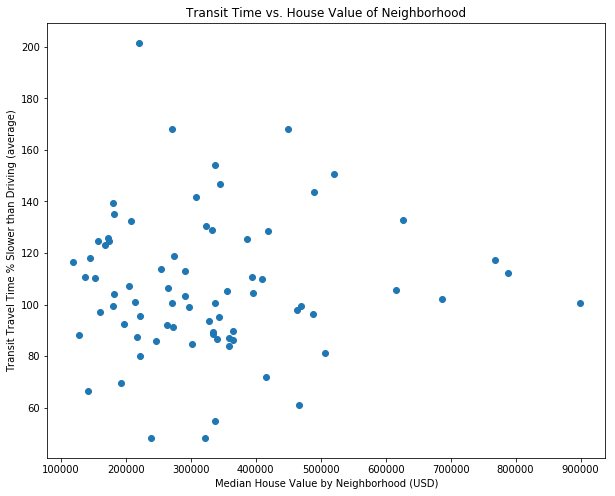

In [26]:
plt.figure(figsize=(10,8))
plt.scatter(df['House Value'], df['Average Transit % Slower'])
plt.title('Transit Time vs. House Value of Neighborhood')
plt.xlabel('Median House Value by Neighborhood (USD)')
plt.ylabel('Transit Travel Time % Slower than Driving (average)')
plt.show()

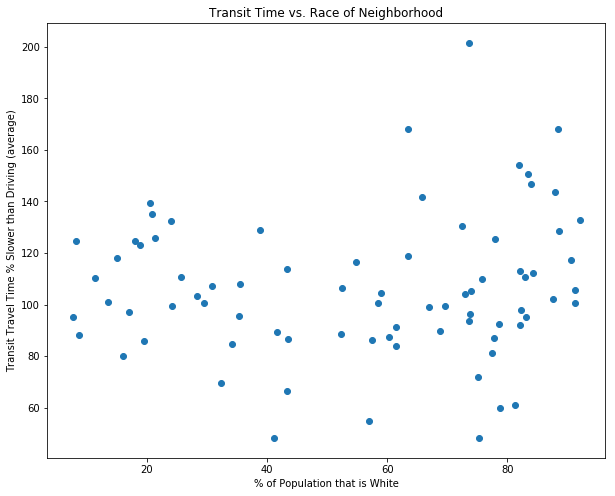

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(df['PCT_WHITE'], df['Average Transit % Slower'])
plt.title('Transit Time vs. Race of Neighborhood')
plt.xlabel('% of Population that is White')
plt.ylabel('Transit Travel Time % Slower than Driving (average)')
plt.show()

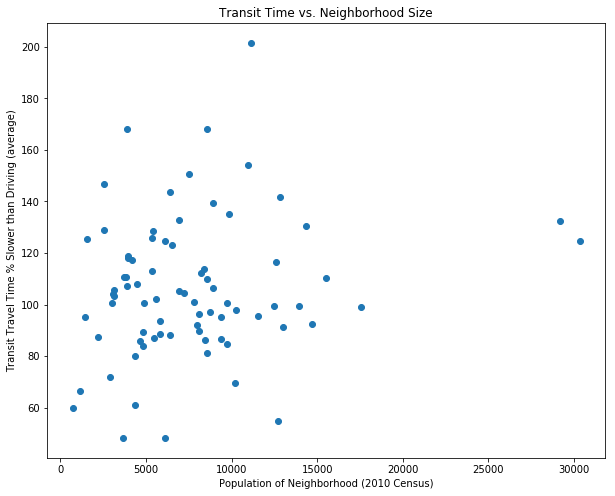

In [32]:
plt.figure(figsize=(10,8))
plt.scatter(df['POPULATION_2010'], df['Average Transit % Slower'])
plt.title('Transit Time vs. Neighborhood Size')
plt.xlabel('Population of Neighborhood (2010 Census)')
plt.ylabel('Transit Travel Time % Slower than Driving (average)')
plt.show()

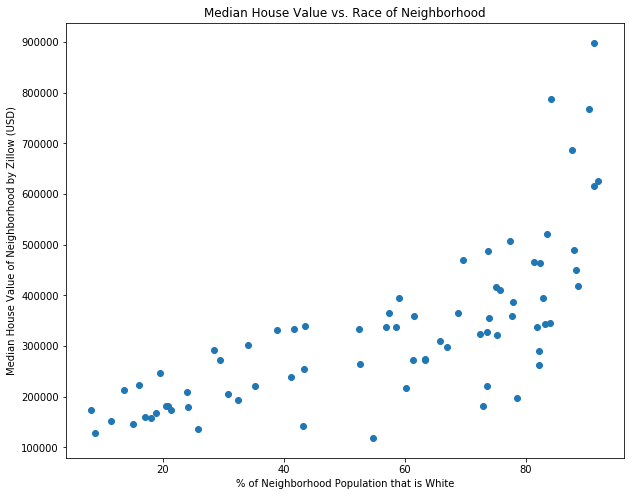

In [28]:
plt.figure(figsize=(10,8))
plt.scatter(df['PCT_WHITE'], df['House Value'])
plt.title('Median House Value vs. Race of Neighborhood')
plt.xlabel('% of Neighborhood Population that is White')
plt.ylabel('Median House Value of Neighborhood by Zillow (USD)')
plt.show()

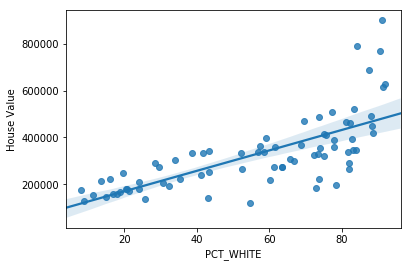

In [29]:
#linear regression
sns.regplot(x="PCT_WHITE", y="House Value", data=df);

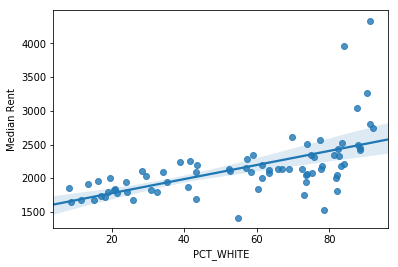

In [30]:
#linear regression
sns.regplot(x="PCT_WHITE", y="Median Rent", data=df);

In [38]:
df.to_csv('raw_data\\neighborhood_commute_and_transit_times.csv')

In [39]:
df.head()

,Neighborhood,House Value,Median Rent,POPULATION_2010,PCT_WHITE,DENVER_REGION,drive-AM-to-Downtown,transit-AM-to-Downtown,drive-PM-from-Downtown,transit-PM-from-Downtown,...,% Slower Rush Hour Drive AM-to-DTC,Transit % Slower AM-to-DTC,% Slower Rush Hour Drive PM-from-DTC,Transit % Slower PM-from-DTC,% Slower Rush Hour Drive AM-to-CU-Boulder,Transit % Slower AM-to-CU-Boulder,% Slower Rush Hour Drive PM-from-CU-Boulder,Transit % Slower PM-from-CU-Boulder,Average % Slower Rush Hour Drive,Average Transit % Slower
0,Montbello,174000.0,1854.0,30348,8.17,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,49.225092,124.727992,36.724566,220.931639,69.955379,100.408401,47.541766,106.599806,61.359118,124.838121
1,Gateway - Green Valley Ranch,208600.0,1951.0,29201,23.98,Northeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,56.443832,200.352423,35.878963,205.355249,16.809006,102.592223,4.315476,149.179743,48.168008,132.352911
2,Hampden,297900.0,2138.0,17547,66.96,Southeast,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,9.702660,107.560628,18.167457,108.288770,47.749900,106.280323,51.106026,59.111560,37.639157,99.242317
3,Westwood,152600.0,1675.0,15486,11.39,West,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,88.411669,87.311828,75.334324,93.177966,39.914974,101.417961,39.929015,94.229550,40.214573,110.209966
4,Capitol Hill,197600.0,1534.0,14708,78.56,Central,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,{'geocoded_waypoints': [{'geocoder_status': 'O...,...,52.433281,84.912461,38.058552,105.970982,36.316533,46.648238,39.241071,43.443411,28.317762,92.355886


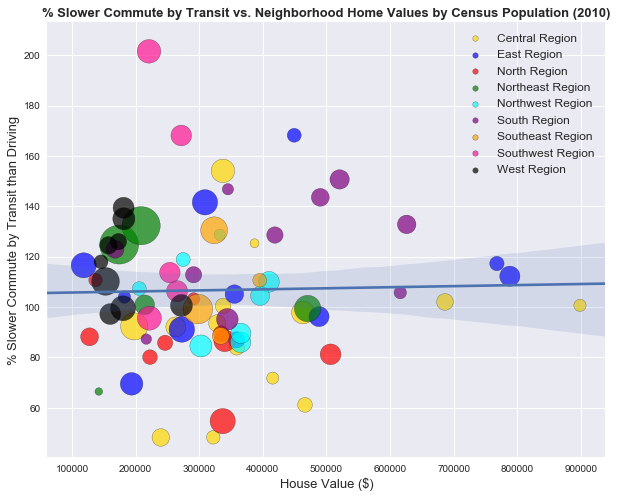

In [52]:
#plt.scatter(% Slower Transit vs Neighborhood Home Values)

central_data  = df.loc[df['DENVER_REGION'] == 'Central']
east_data = df.loc[df['DENVER_REGION'] == 'East']
north_data = df.loc[df['DENVER_REGION'] == 'North']
northeast_data = df.loc[df['DENVER_REGION'] == 'Northeast']
northwest_data = df.loc[df['DENVER_REGION'] == 'Northwest']
south_data = df.loc[df['DENVER_REGION'] == 'South']
southeast_data = df.loc[df['DENVER_REGION'] == 'Southeast']
southwest_data = df.loc[df['DENVER_REGION'] == 'Southwest']
west_data = df.loc[df['DENVER_REGION'] == 'West']

sns.set()
plt.figure(figsize=(10,8))

central_plot = plt.scatter(central_data['House Value'], central_data['Average Transit % Slower'], c='gold', s=central_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='Central Region')
east_plot = plt.scatter(east_data['House Value'], east_data['Average Transit % Slower'], c='blue', s=east_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='East Region')
north_plot = plt.scatter(north_data['House Value'], north_data['Average Transit % Slower'], c='red', s=north_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='North Region')
northeast_plot = plt.scatter(northeast_data['House Value'], northeast_data['Average Transit % Slower'], c='green', s=northeast_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='Northeast Region')
nortwest_plot = plt.scatter(northwest_data['House Value'], northwest_data['Average Transit % Slower'], c='cyan', s=northwest_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='Northwest Region')
south_plot = plt.scatter(south_data['House Value'], south_data['Average Transit % Slower'], c='purple', s=south_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='South Region')
southeast_plot = plt.scatter(southeast_data['House Value'], southeast_data['Average Transit % Slower'], c='orange', s=southeast_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='Southeast Region')
southwest_plot = plt.scatter(southwest_data['House Value'], southwest_data['Average Transit % Slower'], c='deeppink', s=southwest_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='Southwest Region')
west_plot = plt.scatter(west_data['House Value'], west_data['Average Transit % Slower'], c='black', s=west_data['POPULATION_2010']/20, alpha=.7, edgecolor='black', label='West Region')

#include trend line
sns.regplot('House Value', 'Average Transit % Slower', data=df, scatter=False) 

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=12)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]
lgnd.legendHandles[5]._sizes = [30]
lgnd.legendHandles[6]._sizes = [30]
lgnd.legendHandles[7]._sizes = [30]
lgnd.legendHandles[8]._sizes = [30]
plt.xlabel('House Value ($)', fontsize=13)
plt.ylabel('% Slower Commute by Transit than Driving', fontsize=13)
plt.title ('% Slower Commute by Transit vs. Neighborhood Home Values by Census Population (2010)', 
          weight='bold', size=13)
plt.savefig('% Slower Commute by Transit vs. Neighborhood Home Values.png')
plt.show()